### Load Libraries

In [77]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression

from scipy.cluster import hierarchy
from sklearn.decomposition import PCA

In [2]:
[i for i in os.listdir('datos') if i.endswith('.data')]

['abalone.data']

### Load data

In [3]:
data = pd.read_csv('datos/abalone.data', header=None)
data.columns = ["Sex", "Length", "Diam", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
data.head()

,Sex,Length,Diam,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# sns.pairplot(data.drop("Sex", axis=1))

### Fit model with all variables

In [5]:
data_train, data_test = train_test_split(data.drop("Sex", axis=1), test_size=0.2, random_state=42)

In [6]:
X_train, y_train = data_train.drop("Rings", axis=1), data_train["Rings"]
X_test, y_test = data_test.drop("Rings", axis=1), data_test["Rings"]

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
predict = model.predict(X_test)

In [9]:
# calculate r_squared and rmse
r_squared = model.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.5329844757724522
RMSE test: 2.2484530558362525


In [10]:
predict_train = model.predict(X_train)

In [11]:
# calculate r_squared and rmse for train
r_squared = model.score(X_train, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.5260176935365598
RMSE train: 2.2078092227168797


### Fit model after removing correlated features

#### Check Correlation

In [13]:
data.drop(["Sex"], axis=1).corr().style.background_gradient(cmap='coolwarm')

,Length,Diam,Height,Whole,Shucked,Viscera,Shell,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diam,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


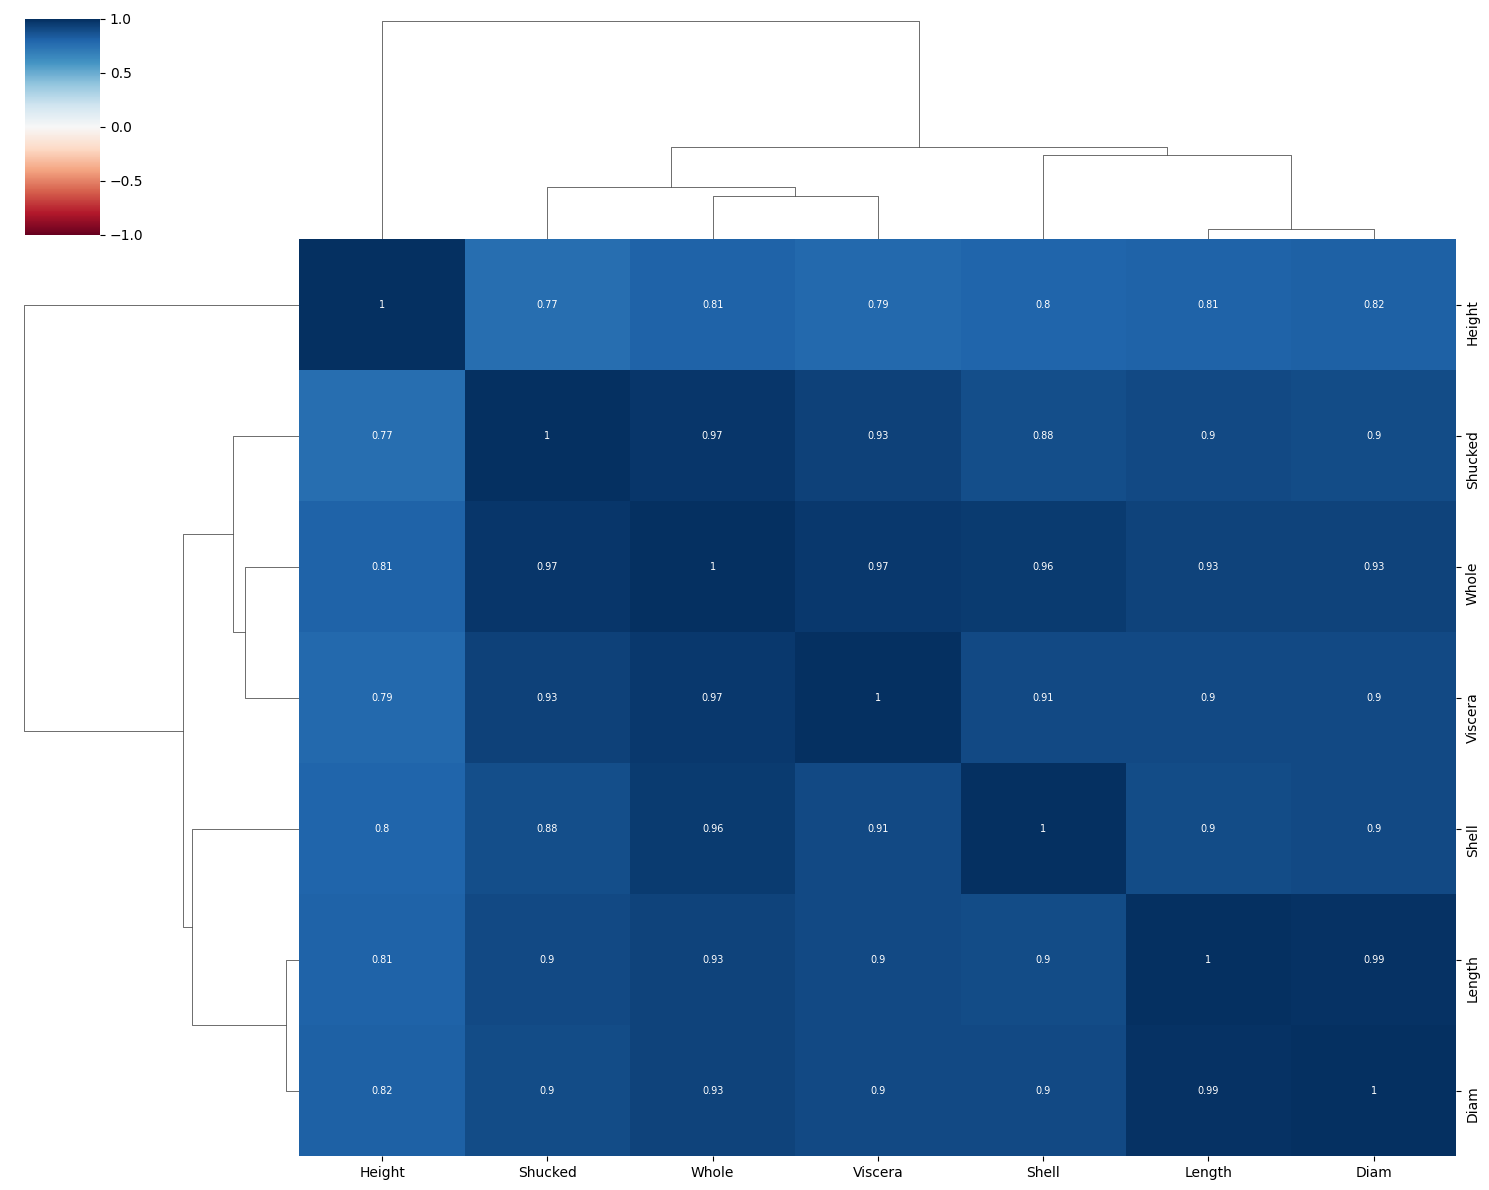

In [14]:
correlation = X_train.corr()
sns.clustermap(correlation, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

Se puden obserar cuatro grupos de variables correlacionadas con un umbral de 0.5

#### Seleccionar variables

In [57]:
def selection_by_corr(dataset, threshold):
    corr_ = (dataset.corr() * -(np.identity(dataset.shape[1]) - 1)).abs()
    while corr_.max().max() > threshold:
        args = np.unravel_index(corr_.to_numpy().argmax(), corr_.shape)
        if corr_.iloc[args[0], :].mean() > corr_.iloc[:, args[1]].mean():
            name_drop = corr_.iloc[args[0], :].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
        else:
            name_drop = corr_.iloc[:, args[1]].name
            corr_.drop(name_drop, axis=1, inplace=True)
            corr_.drop(name_drop, axis=0, inplace=True)
    return corr_.columns.values

In [69]:
select_col = selection_by_corr(X_train, 0.9)
select_col

array(['Height', 'Shucked', 'Shell'], dtype=object)

### Fit model with selected columns

In [63]:
X_train_select = X_train[select_col]
X_test_select = X_test[select_col]

In [64]:
model = LinearRegression()
model.fit(X_train_select, y_train)

LinearRegression()

In [65]:
predict = model.predict(X_test_select)

In [66]:
# calculate r_squared and rmse
r_squared = model.score(X_test_select, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.49185657736622557
RMSE test: 2.345369754064194


In [67]:
predict_train = model.predict(X_train_select)

In [68]:
# calculate r_squared and rmse for train
r_squared = model.score(X_train_select, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.49235393043990694
RMSE train: 2.284867352283487


### PCA

- Se crearan nuevas variables a partir de las variables originales, estas nuevas variables seran las variables originales.
- Se seleccionaran variables en base al grado de varianza.

#### Compute PCA

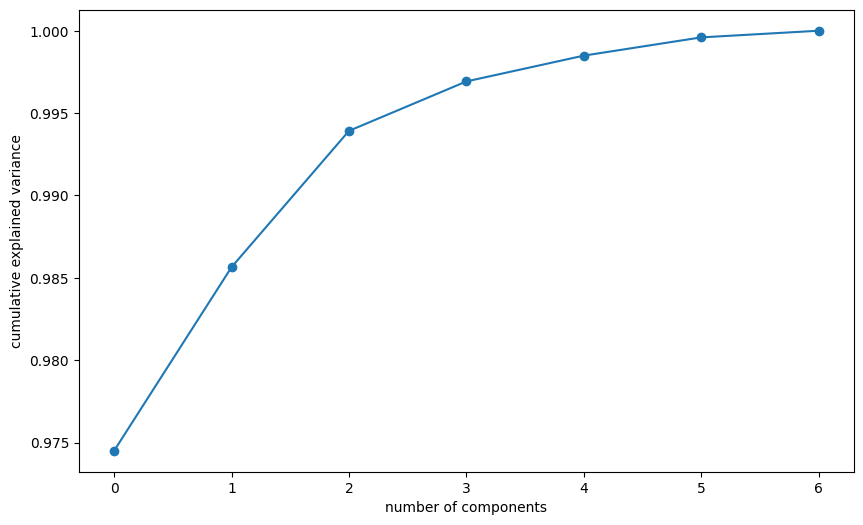

In [78]:
# plot the variance explained for each principal component
pca = PCA().fit(X_train)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# En base a la gráfica anterior, se seleccionan 3 componente principal

#### Seleccion de variables

In [84]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### Graficar

Text(0, 0.5, 'Rings')

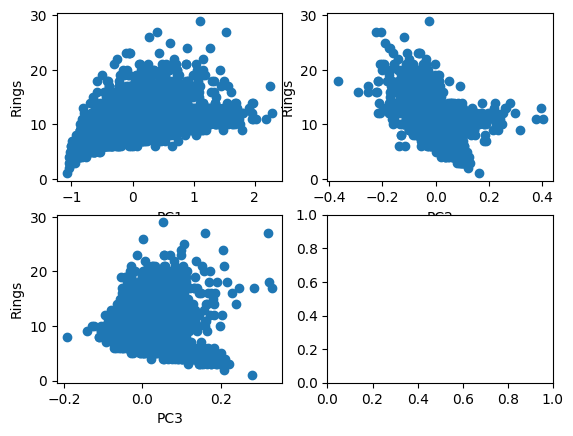

In [88]:
# Graficar las primeras 3 componentes principales
# contra la variable objetivo
fig = plt.subplots(2, 2)
plt.subplot(2, 2, 1)
plt.scatter(X_train_pca[:, 0], y_train)
plt.xlabel('PC1')
plt.ylabel('Rings')
plt.subplot(2, 2, 2)
plt.scatter(X_train_pca[:, 1], y_train)
plt.xlabel('PC2')
plt.ylabel('Rings')
plt.subplot(2, 2, 3)
plt.scatter(X_train_pca[:, 2], y_train)
plt.xlabel('PC3')
plt.ylabel('Rings')

#### Fit a model using the principal components

In [89]:
pca = PCA(n_components=2)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [90]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

In [91]:
predict = model.predict(X_test_pca)

In [92]:
# calculate r_squared and rmse
r_squared = model.score(X_test_pca, y_test)
rmse = np.sqrt(np.mean((predict - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.5095778895187072
RMSE test: 2.3041098838696112


In [93]:
# calculate r_squared and rmse for train
predict_train = model.predict(X_train_pca)
r_squared = model.score(X_train_pca, y_train)
rmse = np.sqrt(np.mean((predict_train - y_train) ** 2))

print(f"R-squared train: {r_squared}")
print(f"RMSE train: {rmse}")

R-squared train: 0.5093811506380302
RMSE train: 2.2462215681426794


### PLS

- Se crearan nuevas variables independientes y dependiente en base a la transformación de las variables originales.
- Se seleccionan las variables independiente hasta que las metricas decrementen.

In [101]:
y_test.shape

(836,)

In [102]:
pls = PLSRegression()
pls.fit(X_train, y_train)

predict = pls.predict(X_test)

# calculate r_squared and rmse
r_squared = pls.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))

print(f"R-squared test: {r_squared}")
print(f"RMSE test: {rmse}")

R-squared test: 0.49488915798823385
RMSE test: 2.338360742286316


#### Plot

In [118]:
pls = PLSRegression(n_components=4)
pls.fit(X_train, y_train)

X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

Text(0, 0.5, 'Rings')

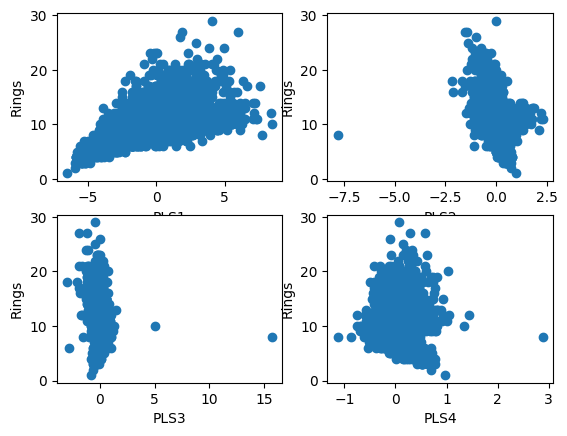

In [120]:
# Graficar las primeras 3 componentes principales
# contra la variable objetivo
fig = plt.subplots(2, 2)
plt.subplot(2, 2, 1)
plt.scatter(X_train_pls[:, 0], y_train)
plt.xlabel('PLS1')
plt.ylabel('Rings')
plt.subplot(2, 2, 2)
plt.scatter(X_train_pls[:, 1], y_train)
plt.xlabel('PLS2')
plt.ylabel('Rings')
plt.subplot(2, 2, 3)
plt.scatter(X_train_pls[:, 2], y_train)
plt.xlabel('PLS3')
plt.ylabel('Rings')
plt.subplot(2, 2, 4)
plt.scatter(X_train_pls[:, 3], y_train)
plt.xlabel('PLS4')
plt.ylabel('Rings')

In [124]:
# Remove variables iteratively
for i in range(X_train.shape[1], 0, -1):
    pls = PLSRegression(n_components=i)
    pls.fit(X_train, y_train)
    print(f"Number of components: {i}")
    # predict train
    predict_train = pls.predict(X_train)
    r_squared = pls.score(X_train, y_train)
    rmse = np.sqrt(np.mean((predict_train.reshape(-1) - y_train) ** 2))
    print(f"R-squared train: {r_squared:.4f}")
    print(f"RMSE train: {rmse:.4f}")
    # predict test
    predict = pls.predict(X_test)
    r_squared = pls.score(X_test, y_test)
    rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))
    print(f"R-squared test: {r_squared:.4f}")
    print(f"RMSE test: {rmse:.4f}")

Number of components: 7
R-squared train: 0.53
RMSE train: 2.21
R-squared test: 0.53
RMSE test: 2.25
Number of components: 6
R-squared train: 0.53
RMSE train: 2.21
R-squared test: 0.53
RMSE test: 2.25
Number of components: 5
R-squared train: 0.52
RMSE train: 2.23
R-squared test: 0.52
RMSE test: 2.29
Number of components: 4
R-squared train: 0.51
RMSE train: 2.24
R-squared test: 0.51
RMSE test: 2.30
Number of components: 3
R-squared train: 0.51
RMSE train: 2.24
R-squared test: 0.51
RMSE test: 2.30
Number of components: 2
R-squared train: 0.48
RMSE train: 2.32
R-squared test: 0.49
RMSE test: 2.34
Number of components: 1
R-squared train: 0.32
RMSE train: 2.63
R-squared test: 0.35
RMSE test: 2.66


Existe un cambio significativo ahasta las 2 componentes, por lo que se utilizara un modelo con 3 componentes.

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)

In [ ]:
predict_train = pls.predict(X_train)
r_squared = pls.score(X_train, y_train)
rmse = np.sqrt(np.mean((predict_train.reshape(-1) - y_train) ** 2))
print(f"R-squared train: {r_squared:.2f}")
print(f"RMSE train: {rmse:.2f}")
# predict test
predict = pls.predict(X_test)
r_squared = pls.score(X_test, y_test)
rmse = np.sqrt(np.mean((predict.reshape(-1) - y_test) ** 2))
print(f"R-squared test: {r_squared:.2f}")
print(f"RMSE test: {rmse:.2f}")